# Jordi Blasco Lozano

## Clustering and Deterministic Annealing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage

## 8.2. Exercise 1:

In [2]:
def generar_datos_gaussianos(n_muestras=100, n_clusters=3, centros=None):
    """
    Genera datos sintéticos siguiendo distribuciones gaussianas.

    Parámetros:
    -----------
    n_muestras : int
        Cantidad de puntos para cada cluster.
    n_clusters : int
        Número de clusters a generar.
    centros : array 
        Coordenadas de los centros (x, y).

    Retorna:
    --------
    X : array
        Coordenadas (x, y) de todos los puntos.
    y : array
        Etiqueta del cluster al que pertenece cada punto.
    """
    X = []
    y = []
    for i in range(n_clusters):
        puntos_x = np.random.normal(centros[i][0], 0.5, n_muestras)
        puntos_y = np.random.normal(centros[i][1], 0.5, n_muestras)
        etiquetas = np.full(n_muestras, i)  # Generamos las etiquetas correctas
        puntos = np.column_stack((puntos_x, puntos_y))  # Creamos un array (N,2)
        X.append(puntos)
        y.append(etiquetas)

    X = np.vstack(X)
    y = np.hstack(y)

    indices = np.arange(len(X))
    np.random.shuffle(indices)
    return X[indices], y[indices]

def visualizar_datos(X, y, centros, n_clusters, titulo=None):
    """
    Visualiza los clusters generados junto con sus centros.

    Parámetros:
    -----------
    X : array
        Coordenadas (x, y) de todos los puntos.
    y : array
        Etiqueta del cluster al que pertenece cada punto.
    centros : array
        Coordenadas de los centros de los clusters.
    n_clusters : int
        Número de clusters a visualizar.
titulo : str, opcional
        Título personalizado para la gráfica.
    """
    plt.figure(figsize=(12, 10))
    colores = ["blue", "red", "magenta", "green", "orange", "cyan", "purple", "yellow", "pink", "brown", "gray"]
    colores = colores[:n_clusters]  # Limitamos la cantidad de colores a los clusters existentes


    for i, c in enumerate(colores):
        mask = (y == i)
        plt.scatter(X[mask, 0], X[mask, 1], color=c, s=50, alpha=0.77, label=f'Cluster {i}')

    
    for i, c in enumerate(colores):
        if i == 0:
            
            plt.scatter(centros[i][0], centros[i][1], color="black", marker='x', s=150, label='Centro')
        else:
            # El resto de centros no se añaden a la leyenda
            plt.scatter(centros[i][0], centros[i][1], color="black", marker='x', s=150)

    plt.legend()
    plt.title(titulo)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()


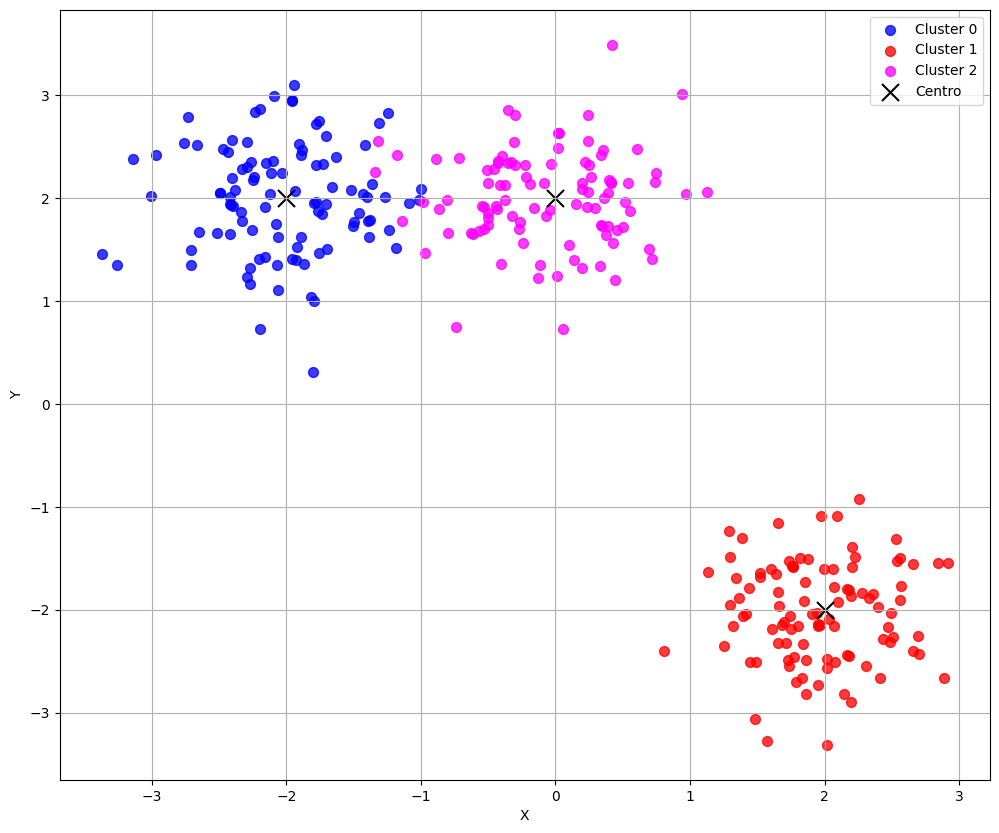

In [3]:
centros = [
    [-2,2],
    [2,-2],
    [0,2],
]
x, y = generar_datos_gaussianos(centros=centros)
visualizar_datos(x, y, centros, 3)

## 8.3. Exercise 2: Implementing Deterministic Annealing

In [4]:

class DeterministicAnnealing:
    def __init__(self, n_clusters=3, T_min=0.01, T_max=5.0, epsilon=1e-6, max_iter=100):
        self.n_clusters = n_clusters
        self.T_min = T_min
        self.T_max = T_max
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.centroids = None
        self.M = None  



    def _calcular_distancia(self, X, centroides):
        """
        Calcula la matriz de distancias euclidianas al cuadrado entre puntos y centroides.
        
        Utilizamos la identidad: ||X-c||² = ||X||² + ||c||² - 2<X,c>
        donde <a,b> es el producto escalar.
        """

        norma_x = np.sum(X ** 2, axis=1, keepdims=True)  
        norma_c = np.sum(centroides ** 2, axis=1)  
        producto_escalar = np.dot(X, centroides.T) 
       
        norma_c = norma_c[np.newaxis, :]  
        
        distancias = norma_x + norma_c - 2 * producto_escalar
        
        return np.maximum(distancias, 0)

    def _actualizar_pertenencia(self, X, centroides, T):
        D = self._calcular_distancia(X, centroides)
        beta = 1 / T
        numerador = np.exp(-beta * (D - np.min(D, axis=1, keepdims=True)))
        
        denominador = np.sum(numerador, axis=1, keepdims=True) + 1e-10
        M = numerador / denominador
        return M

    def _actualizar_centroides(self, X, M):
        numerador = np.dot(M.T, X)
        denominador = np.sum(M, axis=0)[:, np.newaxis]
        cen = numerador / (denominador + 1e-10)
        return cen

    def fit(self, X):
        n_muestras, n_dimensiones = X.shape
        self.centroids = np.random.randn(self.n_clusters, n_dimensiones)

        t = 0
        T = self.T_max
        convergencia = False
        M_anterior = np.ones((n_muestras, self.n_clusters)) / self.n_clusters

        while not convergencia:
            self.M = self._actualizar_pertenencia(X, self.centroids, T)
            self.centroids = self._actualizar_centroides(X, self.M)

            t += 1
            T = 1 / np.log(1 + t)

            diferencia = np.sum(np.abs(self.M - M_anterior))
            if T < self.T_min or t > self.max_iter or diferencia <= self.epsilon:
                convergencia = True

            M_anterior = self.M.copy()

        return self

    def predict(self, X):
        M = self._actualizar_pertenencia(X, self.centroids, self.T_min)
        return np.argmax(M, axis=1)

    def fit_predict(self, X):
        self.fit(X)
        return self.predict(X)
    


    ## 8.5. Exercise 4: Entropy

    def calcular_entropia_por_puntos(self):
        """
        Calcula la entropía condicional H(C|X), que es la entropía por punto.
        
        Esta entropía mide la incertidumbre en la asignación de clusters para cada punto.
        """
        return -np.sum(self.M * np.log(self.M)) / len(self.M)

    def calcular_entropia_por_clusters(self):
        """
        Calcula la entropía condicional H(X|C), que es la entropía por cluster.
        
        Esta entropía mide qué tan uniforme es la distribución de puntos dentro de cada cluster.
        También devuelve un array con las entropías individuales de cada cluster.
        """
        entropia_total = 0
        lista_entropia_por_clusters = []

        for i in range(self.n_clusters):
            p_c = np.sum(self.M[:, i] / len(self.M))
            p_x_dado_c = self.M[:, i] / np.sum(self.M[:, i])
            entropia_por_c = -np.sum(p_x_dado_c * np.log(p_x_dado_c))

            lista_entropia_por_clusters.append(entropia_por_c)
            entropia_total += (p_c * entropia_por_c)

        return entropia_total, np.array(lista_entropia_por_clusters)


## 8.4. Exercise 3: Testing the Algorithm

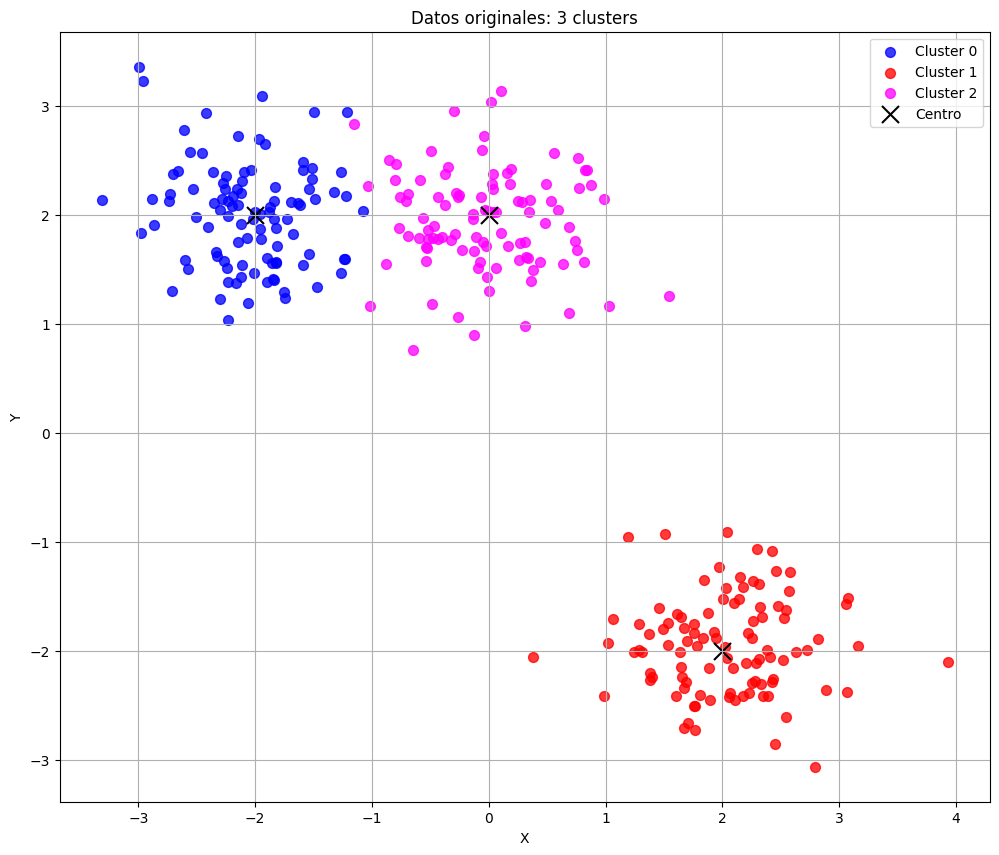

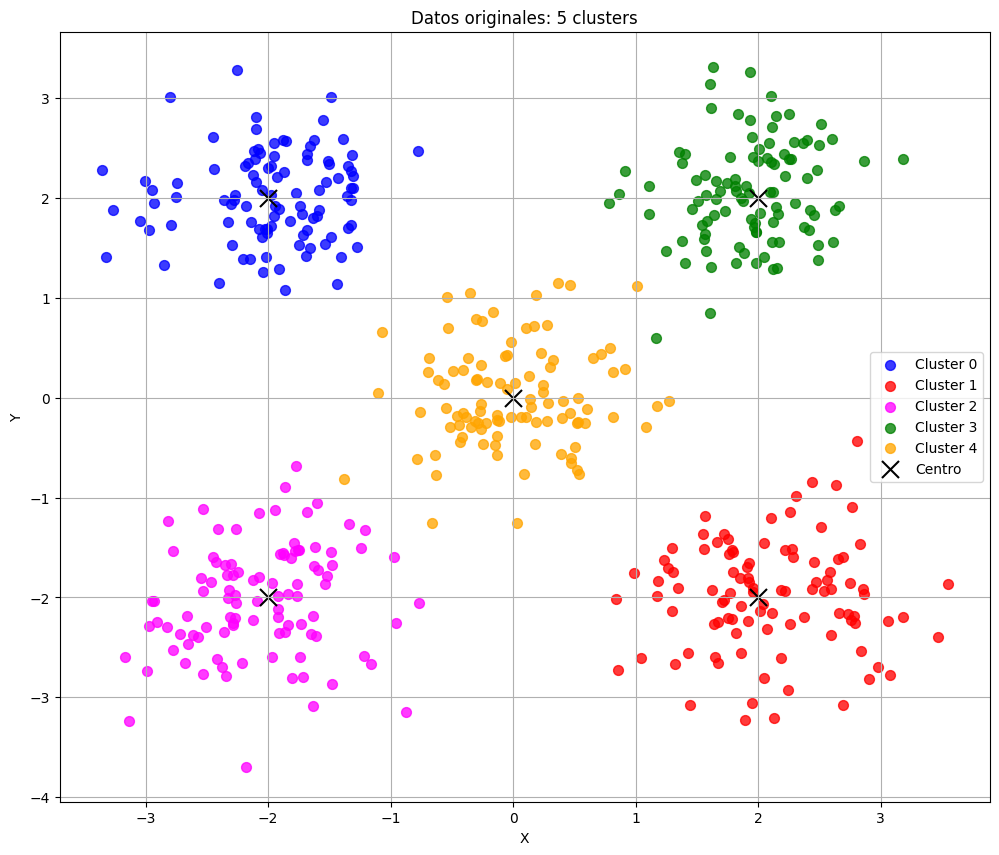

In [5]:

np.random.seed(42)

centros_3clusters = [
    [-2,2],
    [2,-2],
    [0,2],
]
X1, y_true_3clusters = generar_datos_gaussianos(n_muestras=100, n_clusters=3, centros=centros_3clusters)


centros_5clusters = [[-2, 2], [2, -2], [-2, -2], [2, 2], [0, 0]]
X2, y_true_5clusters = generar_datos_gaussianos(n_muestras=100, n_clusters=5, centros=centros_5clusters)



visualizar_datos(X1, y_true_3clusters, centros_3clusters, 3, titulo="Datos originales: 3 clusters")
visualizar_datos(X2, y_true_5clusters, centros_5clusters, 5, titulo="Datos originales: 5 clusters")


### Test Case 1: 3 clusters originales, algoritmo con 6 clusters

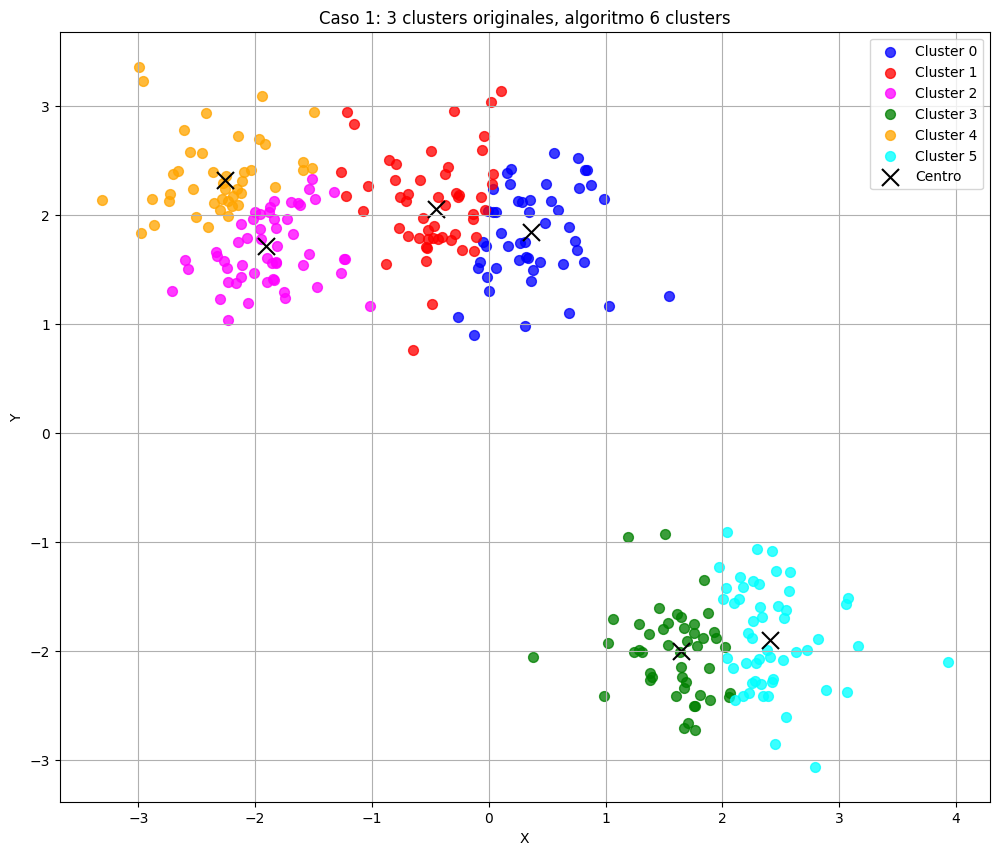

In [6]:
# Test Case 1: 3 clusters originales, algoritmo 6 clusters
modelo1 = DeterministicAnnealing(n_clusters=6)
Y_pred1 = modelo1.fit_predict(X1)
visualizar_datos(X1, Y_pred1, modelo1.centroids, 6, titulo="Caso 1: 3 clusters originales, algoritmo 6 clusters")

### Test Case 2: 3 clusters originales, algoritmo con 2 clusters

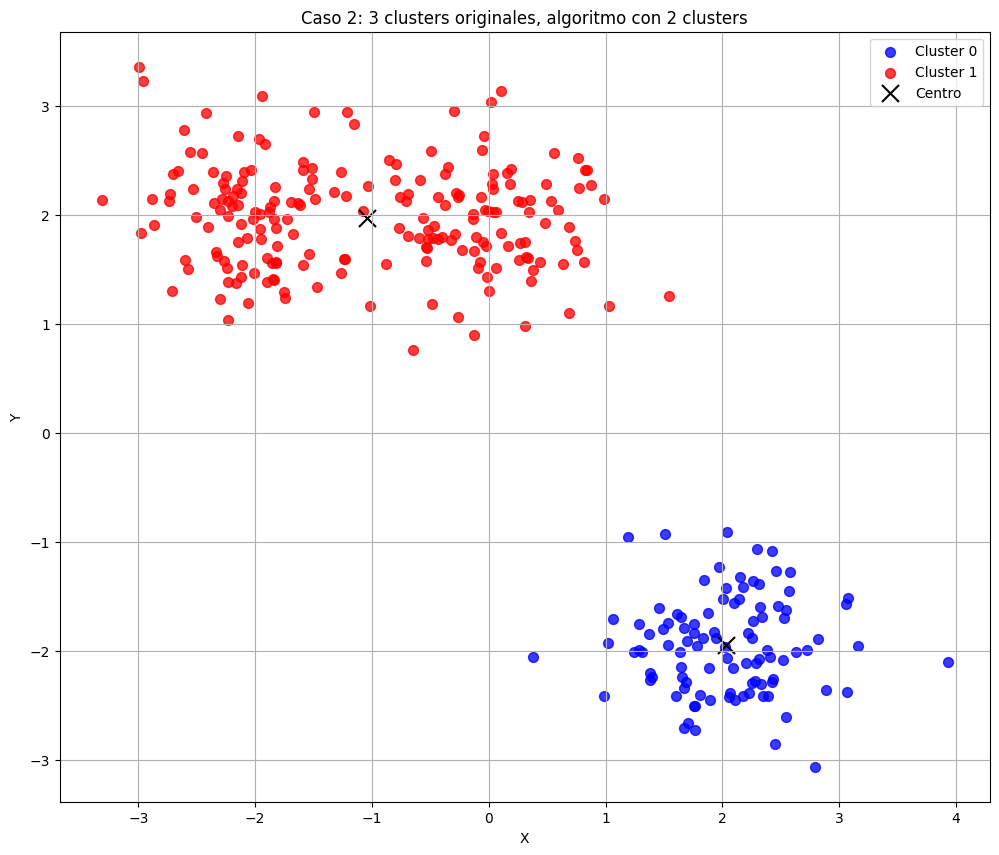

In [7]:
# Test Case 2: 3 clusters originales, algoritmo con 2 clusters
modelo2 = DeterministicAnnealing(n_clusters=2, T_min=0.01, T_max=5.0, max_iter=150)
Y_pred2 = modelo2.fit_predict(X1)


visualizar_datos(X1, Y_pred2, modelo2.centroids, 2, titulo="Caso 2: 3 clusters originales, algoritmo con 2 clusters")


### Test Case 3: 5 clusters originales, algoritmo con 5 clusters

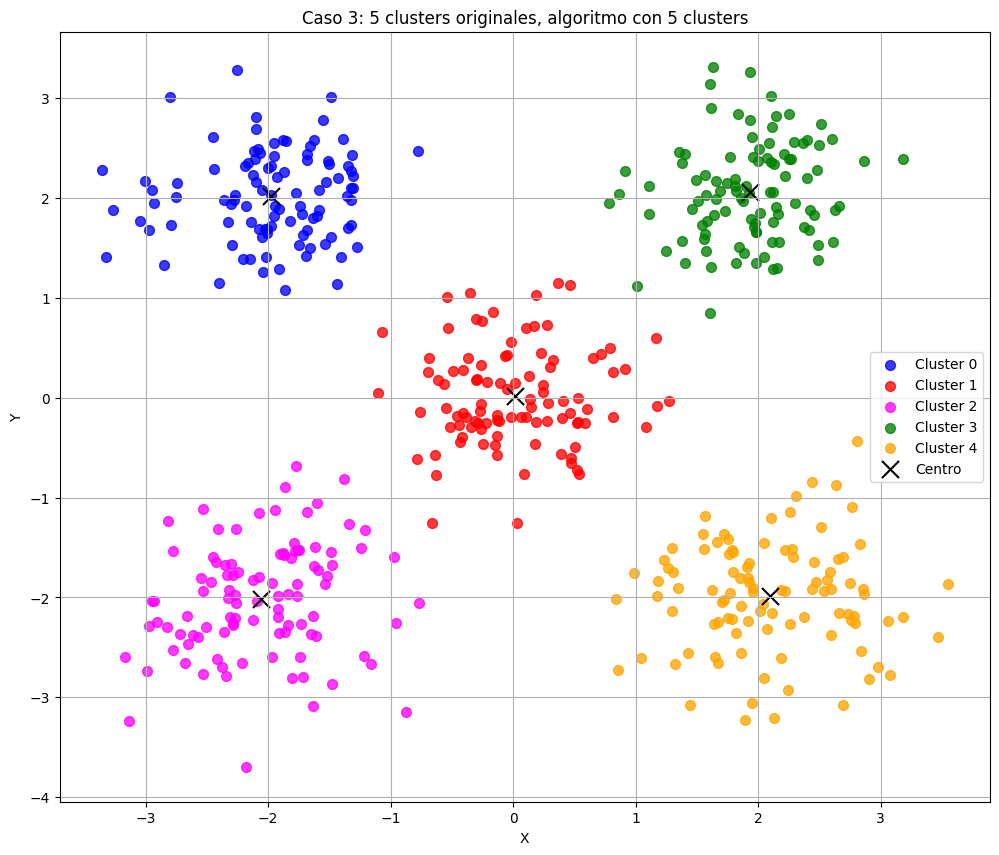

In [8]:
# Test Case 3: 5 clusters originales, algoritmo con 5 clusters
modelo3 = DeterministicAnnealing(n_clusters=5, T_min=0.01, T_max=5.0, max_iter=150)
Y_pred3 = modelo3.fit_predict(X2)

# Visualizamos resultados

visualizar_datos(X2, Y_pred3, modelo3.centroids, 5, titulo="Caso 3: 5 clusters originales, algoritmo con 5 clusters")


### Test Case 4: 5 clusters originales, algoritmo con 2 clusters

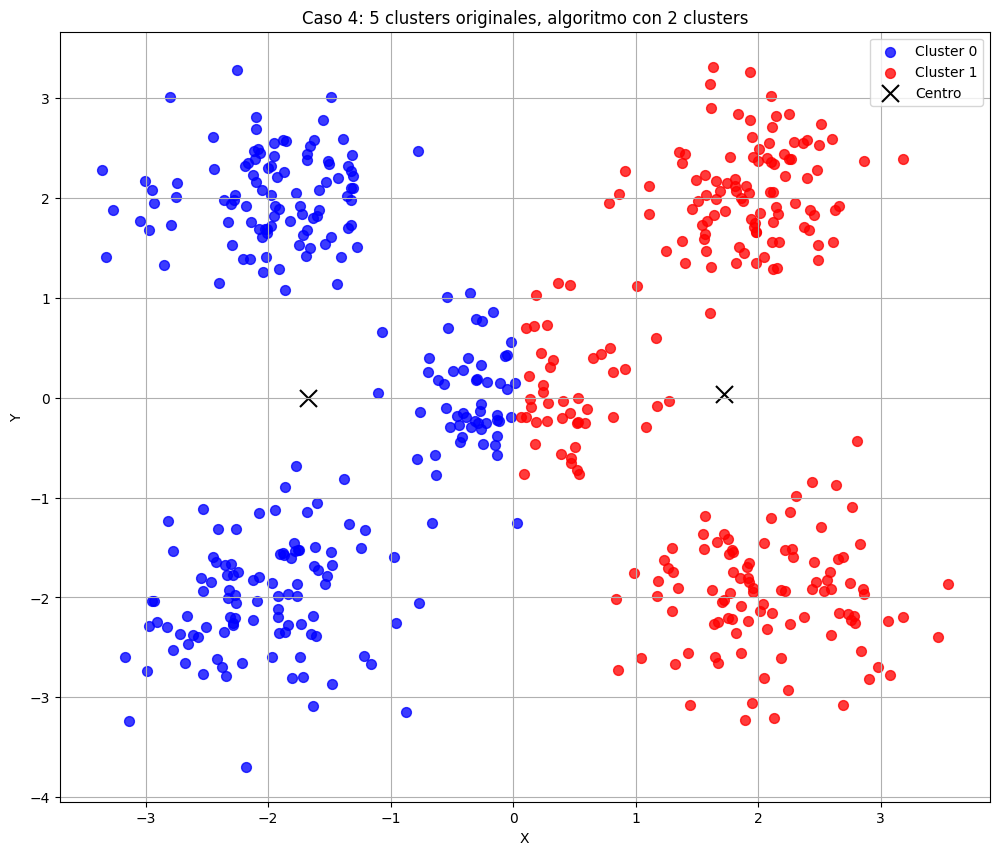

In [9]:
# Test Case 4: 5 clusters originales, algoritmo con 2 clusters
modelo4 = DeterministicAnnealing(n_clusters=2, T_min=0.01, T_max=5.0, max_iter=150)
Y_pred4 = modelo4.fit_predict(X2)

visualizar_datos(X2, Y_pred4, modelo4.centroids, 2, titulo="Caso 4: 5 clusters originales, algoritmo con 2 clusters")


### Test Case 5: 5 clusters originales, algoritmo con 10 clusters

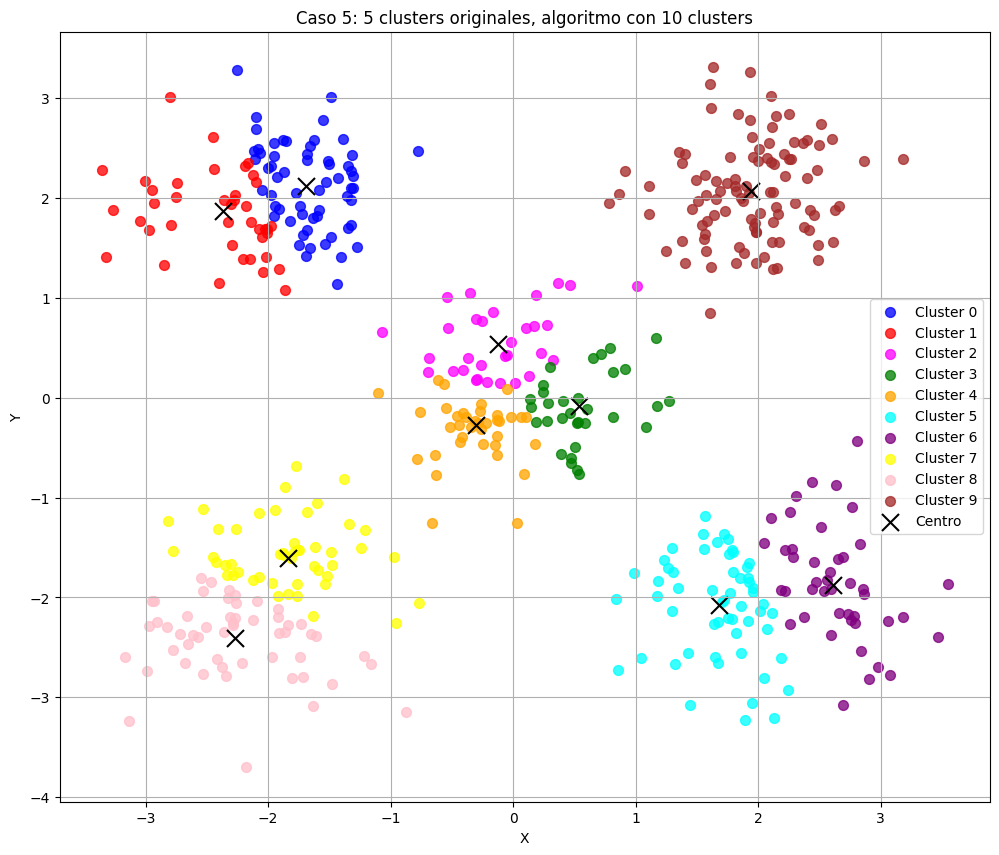

In [10]:
# Test Case 5: 5 clusters originales, algoritmo con 10 clusters
modelo5 = DeterministicAnnealing(n_clusters=10, T_min=0.01, T_max=5.0, max_iter=150)
Y_pred5 = modelo5.fit_predict(X2)


visualizar_datos(X2, Y_pred5, modelo5.centroids, 10, titulo="Caso 5: 5 clusters originales, algoritmo con 10 clusters")



## Ejercicio 5

In [11]:
def inercia_clustering(X, k):
    """
    Ejecuta DA con k clusters y devuelve la entropía total.
    """
    modelo = DeterministicAnnealing(n_clusters=k)
    modelo.fit(X)
    return modelo.calcular_entropia_por_clusters()[0]

def buscar_codo(X, k_min=2, k_max=15):
    """
    Devuelve k_opt y muestra la gráfica basada en la entropía total.
    """
    valores_k = list(range(k_min, k_max + 1))
    entropias = [inercia_clustering(X, k) for k in valores_k]

    # Identificar el codo como el punto con mayor diferencia relativa
    diferencias = np.diff(entropias)
    k_optimo = valores_k[np.argmin(diferencias) + 1]

    
    plt.figure(figsize=(7, 4))
    plt.plot(valores_k, entropias, 'o-r', linewidth=2)
    plt.axvline(k_optimo, color='green', linestyle='--',
                label=f'Óptimo: {k_optimo} clusters')
    for k, e in zip(valores_k, entropias):
        plt.text(k, e, f'{e:.3f}', ha='center', va='bottom', fontsize=8)
    plt.title('Entropía por número de clusters')
    plt.xlabel('Número de clusters')
    plt.ylabel('Entropía')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return 

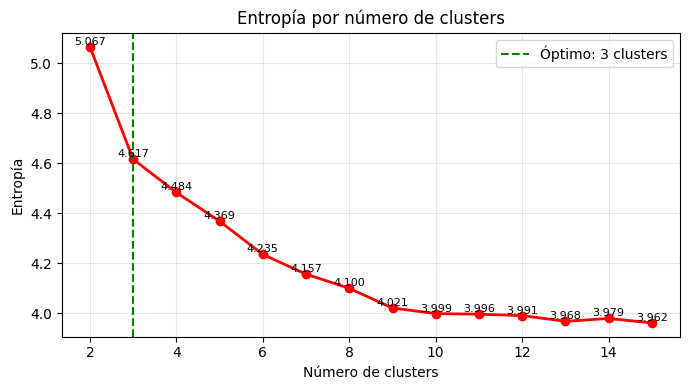

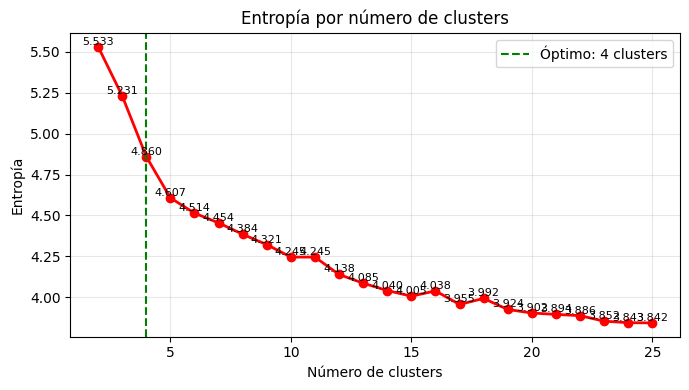

In [12]:
buscar_codo(X1, k_min=2, k_max=15)
buscar_codo(X2, k_min=2, k_max=25)

## 8.7. Exercise 6: Image Segmentation

Shape de la imagen original: (425, 720, 3)
Shape de la imagen reformateada: (306000, 3)


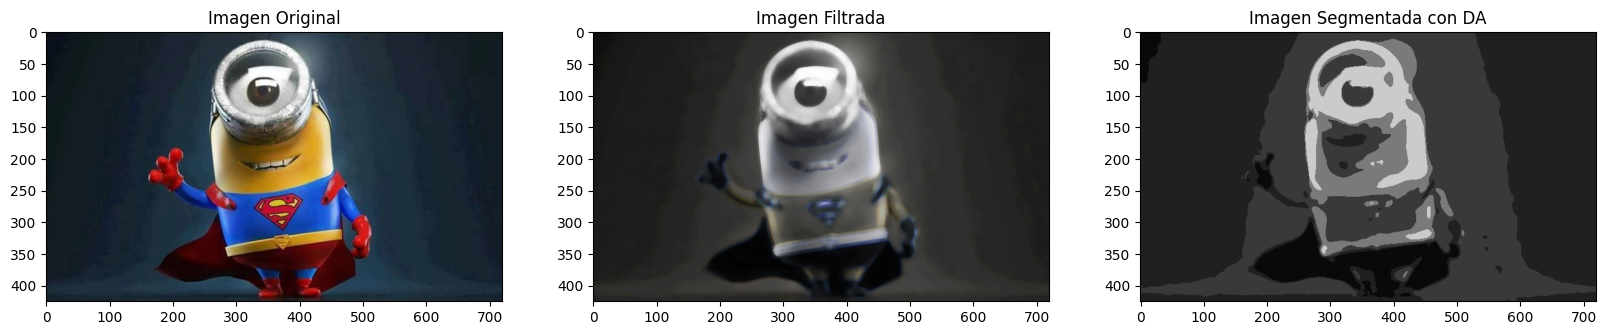

In [13]:
# Fijamos las semillas para reproducibilidad
np.random.seed(42)
# 1. Cargar una imagen
image = np.array(Image.open('imagen.jpg'))

# 2. Preprocesamiento (opcional)
# Aplicar un filtro de mediana para reducir el ruido, cuando decimos ruido nos referimos a que haya demasiada variación en los colores de los píxeles
# en la imagen. Esto puede ayudar a mejorar la segmentación.
image_filtered = ndimage.median_filter(image, size=10) # ndimage.median_filter es una función de SciPy que aplica un filtro de mediana a la imagen. Le pasamos la imagen y el tamaño del filtro (10x10 píxeles en este caso). Esto significa que cada píxel en la imagen filtrada es reemplazado por la mediana de los píxeles en una vecindad de 10x10 píxeles alrededor de él.

# 3. Reformatear la imagen para clustering
print("Shape de la imagen original:", image.shape)
pixel_values = image_filtered.reshape((-1, 3))
print("Shape de la imagen reformateada:", pixel_values.shape)
pixel_values = np.float32(pixel_values)

# Paso 4: Aplicar el algoritmo de Deterministic Annealing
n_clusters = 5  # Número de clusters deseados
modelo = DeterministicAnnealing(n_clusters=n_clusters, T_min=0.01, T_max=5.0, max_iter=150)
modelo.fit(pixel_values)

# Obtener las etiquetas de los clusters
labels = modelo.predict(pixel_values)
# Reconstruir la imagen segmentada
centroids = modelo.centroids.astype(np.uint8)  # Convertimos los centroides a enteros (valores RGB)
segmented_image = centroids[labels]  # Asignamos a cada píxel el color de su centroide
segmented_image = segmented_image.reshape(image_filtered.shape)  # Reformateamos a la forma original de la imagen

# 5. Visualizar los resultados con una figura más grande
plt.figure(figsize=(20, 10))  # Ajustamos el tamaño de la figura
plt.subplot(131)
plt.imshow(image)
plt.title('Imagen Original')

plt.subplot(132)
plt.imshow(image_filtered)
plt.title('Imagen Filtrada')

plt.subplot(133)
plt.imshow(segmented_image)
plt.title('Imagen Segmentada con DA')

plt.show()